# Written on 2024.05.25

This notebook is used to perform 10-fold cross-validation to trained models based on ShallowConvNet.

The idea is to use the same training dataset used for the previously selected models. The workflow is as follows

1. Load the training dataset
2. Generate a 10 fold iterator
3. Generate a model per fold
4. Save accuracies and accuracy plots.

After exporting the models in .h5 format, these files will be used to predict with the testing subset and generate the confusion matrices per each fold (not sure if this is necessary, but I'll do it if I have time)


# **1. Instancies and libraries**

## 1.1 Add EEGNet library to the environmental variable

In [1]:
import sys
path = "/content/EEGNET"
sys.path.append(path)

In [2]:
!pip install pyyaml h5py

## 1.2 Import libraries

In [3]:
# Filesystem
import os
import zipfile

# data processing
import numpy as np
import pandas as pd

# AI-related
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
import itertools
#library for cross validation
from sklearn.model_selection import StratifiedKFold

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

#EEGNET
from EEGModels import ShallowConvNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


# **2. Functions**

## 2.1 Function to visualize the performance of the model

In [4]:
def visualize_results (model, n_epochs):
  epochs = [i for i in range (n_epochs)]
  fig, ax = plt.subplots(1,2)
  train_acc = model.history["accuracy"]
  train_loss = model.history["loss"]
  val_acc = model.history["val_accuracy"]
  val_loss = model.history["val_loss"]
  fig.set_size_inches(16,9)

  ax[0].plot(epochs, train_acc, "go-", label = "Training Accuracy")
  ax[0].plot(epochs, val_acc, "ro-", label = "Validation Accuracy")
  ax[0].set_title("Training and Validation Accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, train_loss, "go-", label = "Training Loss")
  ax[1].plot(epochs, val_loss, "ro-", label = "Validation Loss")
  ax[1].set_title("Training and Validation Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()

## 2.2 **Function** to plot Confusion Matrix

In [5]:
def plot_confusion_matrix (cm,
                           classes,
                           normalize = False,
                           title = 'Confusion Matrix',
                           cmap=plt.cm.Greens
                          ):
  plt.imshow (cm, interpolation='nearest', cmap=cmap)
  plt.title (title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(cm)

  thresh = cm.max()*0.80
  for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, round(cm[i,j],2),
              horizontalalignment="center",
              color="white" if cm [i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

## 2.3 Function to normalize EEG data (run inside the loop to assemble the tensor)

In [6]:
def normalize_channels (data, n_channels):
  data_norm = np.zeros_like(data, dtype='float32')
  for ch in range (n_channels):
      min_val = (np.min(data[ch]))
      max_val = (np.max(data[ch]))
      data_norm [ch] = (data[ch] - min_val) / (max_val - min_val)

  return data_norm

# **3. Data Load**

## 3.1 Unzip dataset

In [7]:
local_zip = "/content/ERP_Pretest_Data_128Hz.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/ERP_Pretest_Data_128_Hz")
zip_ref.close()

## 3.2 Define file paths

In [8]:
train_data_path = "/content/ERP_Pretest_Data_128_Hz/Train/"

## 3.3 Load file lists

In [9]:
trainlist = open  ("/content/ERP_Pretest_Data_128_Hz/TrainFileList.txt", "r")
data = trainlist.read()
train_data_all_files = data.split("\n")

## 3.4 Determine the number of trials available based on the number of files

In [10]:
n_trials_train = len(train_data_all_files)

## 3.5 Define the parameters for EEG data

In [11]:
n_channels = 20
n_samples = 128
n_kernels = 1

ch_names = ['Fz', 'F7', 'F3', 'F4', 'F8',
            'T7', 'C3', 'CZ', 'C4', 'T8',
            'P7', 'P3', 'Pz', 'P4', 'P8',
            'O1', 'Oz', 'O2', 'LM', 'RM']

sfreq = 128
#info = mne.create_info(ch_names = ch_names, sfreq = sfreq)

## 3.6 Load training data

This data will be loaded as 2D array for augmentation and balancing

In [12]:
train_set_2D = np.zeros ((n_trials_train,n_channels*n_samples), dtype='float32')

In [13]:
trial = 0
for filename in train_data_all_files:
  data = pd.read_csv(filename, header=None, dtype=np.float32)
  trl = np.reshape (np.array(data), (n_channels*n_samples))
  train_set_2D[trial:] = trl
  trial=trial+1

Load labels for training data

In [14]:
train_labels_path = '/content/ERP_Pretest_Data_128_Hz/TrainLabels.csv'
y_0 = np.array(pd.read_csv(train_labels_path, header=None, dtype='uint8'))
y_0 = np.squeeze(y_0.T)

Balance the training set using the Random Oversampler

In [15]:
oversampler_train = RandomOverSampler(sampling_strategy='minority')
traindata_over, trainlabels_over = oversampler_train.fit_resample(train_set_2D, y_0)
(overTrials_tr, overSamples_tr) = traindata_over.shape

Allocate data in tensor

In [16]:
X = np.zeros((overTrials_tr,n_channels,n_samples), dtype=np.float32)

In [17]:
for i in range(overTrials_tr):
  trl_rs = np.reshape (traindata_over[i],(n_channels,n_samples))
  # Optional operation to check if this improves the model performance
  trl_rs = normalize_channels(np.array(trl_rs, dtype='float32'), n_channels)
  X[i] = trl_rs

# reasign the training labels
y = trainlabels_over
print(y.shape)

(1342,)


## 3.7 Load test data


In [18]:
test_data_path = "/content/ERP_Pretest_Data_128_Hz/Test/"

testlist = open  ("/content/ERP_Pretest_Data_128_Hz/TestFileList.txt", "r")
data_ = testlist.read()
test_data_all_files = data_.split("\n")

n_trials_test = len(test_data_all_files)

In [19]:
n_trials_test = len(test_data_all_files)
test_set_2D = np.zeros ((n_trials_test,n_channels*n_samples), dtype='float32')

In [20]:
trial = 0
for filename in test_data_all_files:
  data = pd.read_csv(filename, header=None, dtype=np.float32)
  trl = np.reshape (np.array(data), (n_channels*n_samples))
  test_set_2D[trial:] = trl
  trial=trial+1

Load test data labels

In [21]:
test_labels_path = '/content/ERP_Pretest_Data_128_Hz/TestLabels.csv'
test_labels = np.array(pd.read_csv(test_labels_path, header=None, dtype='uint8'))
test_labels = np.squeeze(test_labels.T)

Balance with Random Oversampler

In [22]:
oversampler_test = RandomOverSampler(sampling_strategy='minority')
testdata_over, testlabel_over = oversampler_test.fit_resample(test_set_2D, test_labels)
(overTrials_ts,overSamples_ts) = testdata_over.shape

Allocate in tensor

In [23]:
X_test = np.zeros((overTrials_ts,n_channels,n_samples), dtype=np.float32)

In [24]:
for i in range(overTrials_ts):
  trl_rs = np.reshape (testdata_over[i],(n_channels,n_samples))
  # Optional operation to check if this improves the model performance
  trl_rs = normalize_channels(np.array(trl_rs, dtype='float32'), n_channels)
  X_test[i] = trl_rs

# reasign the training labels
y_test = testlabel_over
print(y_test.shape)

(350,)


# 4 ShallowConv Section

# 4.1 Define parameters for architecture

In [25]:
# Model Build
classes = 2
dropout_rate = 0.2                  # hp.Float  ('dropoutRate',  min_value=0.2, max_value=0.5, sampling="log")

# Compile
lr = 1e-4                           # hp.Float  ('learning_rate',  min_value=1e-6, max_value=1e-2, sampling="log")

batch = 16
epoch = 300

# 4.2 Generate model architecture

In [26]:
Shallow_Model = ShallowConvNet(nb_classes = classes,
                       Chans = n_channels,
                       Samples = n_samples,
                       dropoutRate = dropout_rate)

Shallow_Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 116, 40)       560       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 116, 40)        32000     
                                                                 
 batch_normalization (Batch  (None, 1, 116, 40)        160       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1, 116, 40)        0         
                                                                 
 average_pooling2d (Average  (None, 1, 12, 40)         0         
 Pooling2D)                                                  

# 5. Cross-validation settings

# 5.1 Parameters for the ROC curve analysis

In [27]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, roc_curve, auc

accuracies = []

# data containers for unknown class
precisions_unknown = []
recalls_unknown = []
specificities_unknown = []

roc_aucs_unknown = []
tprs_unknown = []
#mean_fpr_unknown = np.linspace(0, 1, 100)

# data containers for known class
precisions_known = []
recalls_known = []
specificities_known = []

roc_aucs_known = []
tprs_known = []

fold = 0
n_folds = 10

5.2 ROC

Epoch 1/300

Epoch 1: val_loss improved from inf to 0.68240, saving model to /tmp/checkpoint0.h5
76/76 - 10s - loss: 0.7012 - accuracy: 0.5269 - val_loss: 0.6824 - val_accuracy: 0.5481 - 10s/epoch - 131ms/step
Epoch 2/300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.68240 to 0.67364, saving model to /tmp/checkpoint0.h5
76/76 - 0s - loss: 0.6618 - accuracy: 0.6288 - val_loss: 0.6736 - val_accuracy: 0.5852 - 362ms/epoch - 5ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.67364
76/76 - 0s - loss: 0.6391 - accuracy: 0.6520 - val_loss: 0.6752 - val_accuracy: 0.5852 - 345ms/epoch - 5ms/step
Epoch 4/300

Epoch 4: val_loss improved from 0.67364 to 0.66528, saving model to /tmp/checkpoint0.h5
76/76 - 0s - loss: 0.6158 - accuracy: 0.7117 - val_loss: 0.6653 - val_accuracy: 0.6148 - 369ms/epoch - 5ms/step
Epoch 5/300

Epoch 5: val_loss improved from 0.66528 to 0.66475, saving model to /tmp/checkpoint0.h5
76/76 - 0s - loss: 0.5930 - accuracy: 0.7142 - val_loss: 0.6647 - val_accuracy: 0.6222 - 365ms/epoch - 5ms/step
Epoch 6/300

Epoch 6: val_loss improved from 0.66475 to 0.64798, saving model to /tmp/checkpoint0.h5
76/76 - 0s - loss: 0.5778 - accuracy: 0.7423 - val_loss: 0.6480 - val_accuracy: 0.6667 - 390ms/epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.21980
76/76 - 0s - loss: 0.2514 - accuracy: 0.9536 - val_loss: 0.2305 - val_accuracy: 0.9852 - 320ms/epoch - 4ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.21980
76/76 - 0s - loss: 0.2419 - accuracy: 0.9644 - val_loss: 0.2337 - val_accuracy: 0.9852 - 326ms/epoch - 4ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.21980
76/76 - 0s - loss: 0.2424 - accuracy: 0.9644 - val_loss: 0.2427 - val_accuracy: 0.9852 - 318ms/epoch - 4ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.21980
76/76 - 0s - loss: 0.2444 - accuracy: 0.9693 - val_loss: 0.2573 - val_accuracy: 0.9852 - 315ms/epoch - 4ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 0.21980
76/76 - 0s - loss: 0.2425 - accuracy: 0.9669 - val_loss: 0.2560 - val_accuracy: 0.9630 - 347ms/epoch - 5ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 0.21980
76/76 - 0s - loss: 0.2415 - accuracy: 0.9577 - val_loss: 0.2437 - val_accuracy: 0.9778 - 329

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.21747
76/76 - 0s - loss: 0.2530 - accuracy: 0.9611 - val_loss: 0.2232 - val_accuracy: 0.9701 - 344ms/epoch - 5ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.21747
76/76 - 0s - loss: 0.2465 - accuracy: 0.9652 - val_loss: 0.2291 - val_accuracy: 0.9701 - 323ms/epoch - 4ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.21747
76/76 - 0s - loss: 0.2470 - accuracy: 0.9627 - val_loss: 0.2379 - val_accuracy: 0.9776 - 374ms/epoch - 5ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.21747
76/76 - 0s - loss: 0.2457 - accuracy: 0.9685 - val_loss: 0.2272 - val_accuracy: 0.9701 - 438ms/epoch - 6ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 0.21747
76/76 - 0s - loss: 0.2398 - accuracy: 0.9677 - val_loss: 0.2540 - val_accuracy: 0.9701 - 459ms/epoch - 6ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 0.21747
76/76 - 0s - loss: 0.2366 - accuracy: 0.9661 - val_loss: 0.2441 - val_accuracy: 0.9701 - 490

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.23270
76/76 - 0s - loss: 0.2348 - accuracy: 0.9694 - val_loss: 0.2377 - val_accuracy: 0.9627 - 336ms/epoch - 4ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.23270
76/76 - 0s - loss: 0.2397 - accuracy: 0.9702 - val_loss: 0.2497 - val_accuracy: 0.9701 - 335ms/epoch - 4ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.23270
76/76 - 0s - loss: 0.2440 - accuracy: 0.9644 - val_loss: 0.2538 - val_accuracy: 0.9478 - 338ms/epoch - 4ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.23270
76/76 - 0s - loss: 0.2352 - accuracy: 0.9702 - val_loss: 0.2406 - val_accuracy: 0.9701 - 352ms/epoch - 5ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 0.23270
76/76 - 0s - loss: 0.2319 - accuracy: 0.9776 - val_loss: 0.2592 - val_accuracy: 0.9328 - 325ms/epoch - 4ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 0.23270
76/76 - 0s - loss: 0.2454 - accuracy: 0.9669 - val_loss: 0.2551 - val_accuracy: 0.9701 - 341

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.21295
76/76 - 0s - loss: 0.2517 - accuracy: 0.9578 - val_loss: 0.2294 - val_accuracy: 0.9776 - 330ms/epoch - 4ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.21295
76/76 - 0s - loss: 0.2451 - accuracy: 0.9611 - val_loss: 0.2346 - val_accuracy: 0.9776 - 340ms/epoch - 4ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.21295
76/76 - 0s - loss: 0.2442 - accuracy: 0.9611 - val_loss: 0.2388 - val_accuracy: 0.9851 - 326ms/epoch - 4ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.21295
76/76 - 0s - loss: 0.2464 - accuracy: 0.9627 - val_loss: 0.2425 - val_accuracy: 0.9925 - 338ms/epoch - 4ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 0.21295
76/76 - 0s - loss: 0.2424 - accuracy: 0.9694 - val_loss: 0.2259 - val_accuracy: 0.9925 - 346ms/epoch - 5ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 0.21295
76/76 - 0s - loss: 0.2364 - accuracy: 0.9702 - val_loss: 0.2345 - val_accuracy: 0.9776 - 333

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.20128 to 0.19970, saving model to /tmp/checkpoint5.h5
76/76 - 0s - loss: 0.2438 - accuracy: 0.9636 - val_loss: 0.1997 - val_accuracy: 1.0000 - 379ms/epoch - 5ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.19970
76/76 - 0s - loss: 0.2423 - accuracy: 0.9661 - val_loss: 0.2044 - val_accuracy: 0.9925 - 347ms/epoch - 5ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.19970
76/76 - 0s - loss: 0.2458 - accuracy: 0.9619 - val_loss: 0.2227 - val_accuracy: 0.9776 - 341ms/epoch - 4ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.19970
76/76 - 0s - loss: 0.2387 - accuracy: 0.9719 - val_loss: 0.2194 - val_accuracy: 0.9851 - 344ms/epoch - 5ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 0.19970
76/76 - 0s - loss: 0.2427 - accuracy: 0.9719 - val_loss: 0.2164 - val_accuracy: 0.9851 - 341ms/epoch - 4ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 0.19970
76/76 - 0s - loss: 0.2394 - accuracy: 0.9685 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.21263
76/76 - 0s - loss: 0.2420 - accuracy: 0.9685 - val_loss: 0.2199 - val_accuracy: 0.9701 - 350ms/epoch - 5ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.21263
76/76 - 0s - loss: 0.2446 - accuracy: 0.9743 - val_loss: 0.2220 - val_accuracy: 0.9627 - 335ms/epoch - 4ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.21263
76/76 - 0s - loss: 0.2415 - accuracy: 0.9669 - val_loss: 0.2400 - val_accuracy: 0.9552 - 351ms/epoch - 5ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.21263
76/76 - 0s - loss: 0.2425 - accuracy: 0.9743 - val_loss: 0.2273 - val_accuracy: 0.9701 - 342ms/epoch - 5ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 0.21263
76/76 - 0s - loss: 0.2396 - accuracy: 0.9644 - val_loss: 0.2306 - val_accuracy: 0.9776 - 340ms/epoch - 4ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 0.21263
76/76 - 0s - loss: 0.2331 - accuracy: 0.9743 - val_loss: 0.2329 - val_accuracy: 0.9627 - 393

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.20014
76/76 - 1s - loss: 0.2378 - accuracy: 0.9694 - val_loss: 0.2129 - val_accuracy: 0.9925 - 511ms/epoch - 7ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.20014
76/76 - 0s - loss: 0.2452 - accuracy: 0.9652 - val_loss: 0.2157 - val_accuracy: 0.9851 - 363ms/epoch - 5ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.20014
76/76 - 0s - loss: 0.2458 - accuracy: 0.9652 - val_loss: 0.2316 - val_accuracy: 0.9851 - 380ms/epoch - 5ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.20014
76/76 - 0s - loss: 0.2425 - accuracy: 0.9652 - val_loss: 0.2194 - val_accuracy: 1.0000 - 329ms/epoch - 4ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 0.20014
76/76 - 0s - loss: 0.2396 - accuracy: 0.9710 - val_loss: 0.2401 - val_accuracy: 0.9851 - 363ms/epoch - 5ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 0.20014
76/76 - 0s - loss: 0.2385 - accuracy: 0.9727 - val_loss: 0.2141 - val_accuracy: 0.9925 - 340

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.22275
76/76 - 0s - loss: 0.2431 - accuracy: 0.9603 - val_loss: 0.2323 - val_accuracy: 0.9925 - 342ms/epoch - 5ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.22275
76/76 - 0s - loss: 0.2378 - accuracy: 0.9644 - val_loss: 0.2509 - val_accuracy: 0.9925 - 345ms/epoch - 5ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.22275
76/76 - 0s - loss: 0.2353 - accuracy: 0.9743 - val_loss: 0.2341 - val_accuracy: 0.9925 - 335ms/epoch - 4ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.22275
76/76 - 0s - loss: 0.2331 - accuracy: 0.9743 - val_loss: 0.2345 - val_accuracy: 0.9925 - 351ms/epoch - 5ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 0.22275
76/76 - 0s - loss: 0.2407 - accuracy: 0.9710 - val_loss: 0.2300 - val_accuracy: 0.9925 - 338ms/epoch - 4ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 0.22275
76/76 - 0s - loss: 0.2384 - accuracy: 0.9719 - val_loss: 0.2454 - val_accuracy: 0.9925 - 342

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.21886 to 0.21654, saving model to /tmp/checkpoint9.h5
76/76 - 0s - loss: 0.2440 - accuracy: 0.9735 - val_loss: 0.2165 - val_accuracy: 0.9701 - 393ms/epoch - 5ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 0.21654
76/76 - 0s - loss: 0.2440 - accuracy: 0.9652 - val_loss: 0.2187 - val_accuracy: 0.9776 - 352ms/epoch - 5ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.21654
76/76 - 0s - loss: 0.2372 - accuracy: 0.9743 - val_loss: 0.2373 - val_accuracy: 0.9552 - 350ms/epoch - 5ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.21654
76/76 - 0s - loss: 0.2418 - accuracy: 0.9677 - val_loss: 0.2521 - val_accuracy: 0.9627 - 324ms/epoch - 4ms/step
Epoch 6/300

Epoch 6: val_loss did not improve from 0.21654
76/76 - 0s - loss: 0.2458 - accuracy: 0.9685 - val_loss: 0.2295 - val_accuracy: 0.9776 - 354ms/epoch - 5ms/step
Epoch 7/300

Epoch 7: val_loss did not improve from 0.21654
76/76 - 0s - loss: 0.2403 - accuracy: 0.9685 - val_

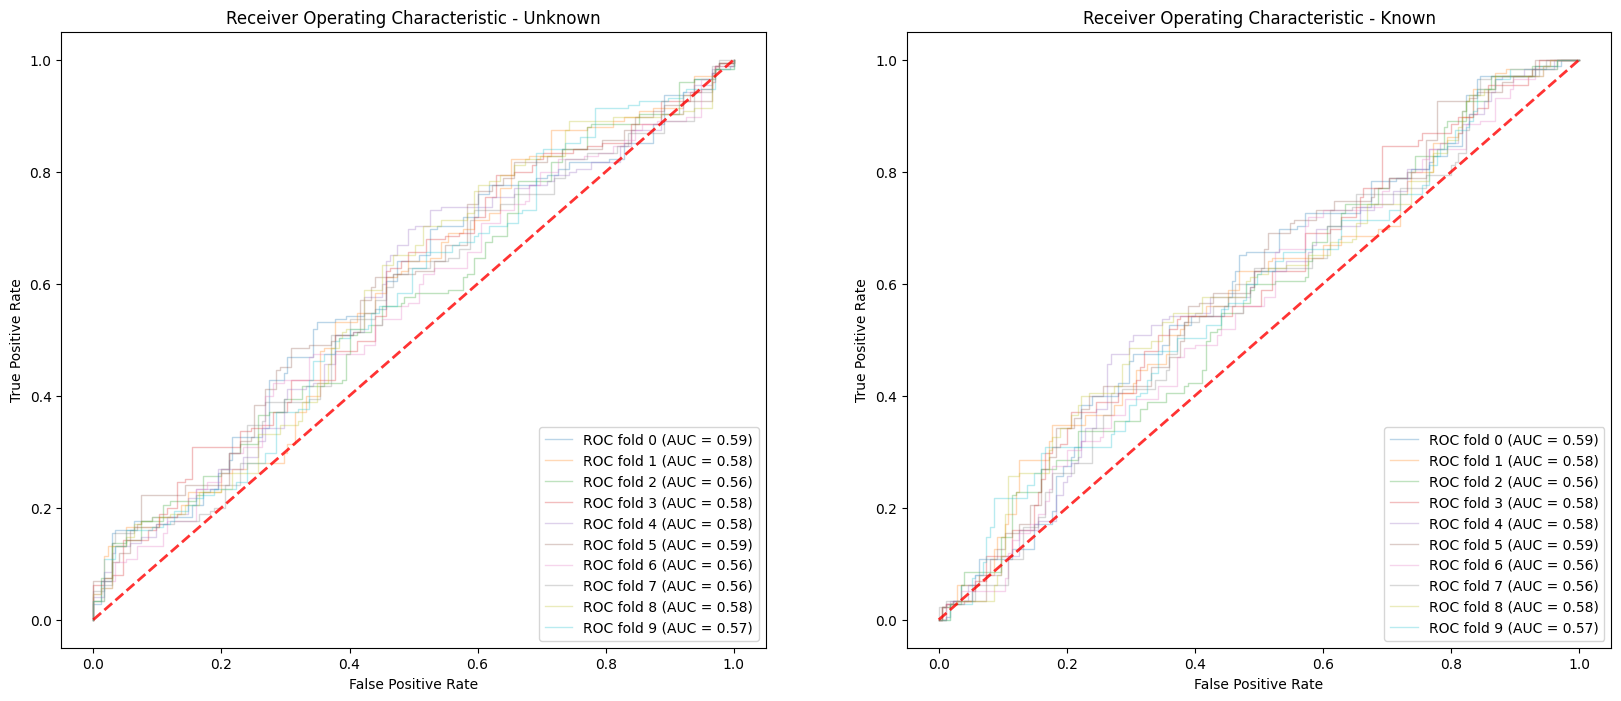

In [29]:
import keras
from keras import optimizers

n_splits = 10

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Perform n-fold cross-validation
# for train_index, val_index in skf.split(X, y):
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # reshape to one-hot encodings
    # datasets
    X_train = X_train.reshape(X_train.shape[0], n_channels, n_samples, n_kernels)
    X_val  = X_val.reshape(X_val.shape[0], n_channels, n_samples, n_kernels)

    #labels
    y_train = np_utils.to_categorical(y_train)
    y_val = np_utils.to_categorical(y_val)


    opt = keras.optimizers.Adam(learning_rate = lr)

    #Checkpointer
    checkpoint_filename = '/tmp/'+'checkpoint' + str (fold) + '.h5'
    checkpointer = ModelCheckpoint(filepath=checkpoint_filename,
                                   verbose=1,
                                   save_best_only=True)

    Shallow_Model.compile(loss='binary_crossentropy',
                         optimizer=opt,
                         metrics = ['accuracy'])

    #load weights from externalfile
    #Shallow_Model.load_weights('/content/Weights/ShallowConvNet_Model1.h5')


    fittedModel = Shallow_Model.fit(X_train,
                                    y_train,
                                    batch_size = batch,
                                    epochs = epoch,
                                    verbose = 2,
                                    validation_data=(X_val, y_val),
                                    callbacks=[checkpointer])

    # load optimal weights
    Shallow_Model.load_weights(checkpoint_filename)



    # make predictions on test data
    y_probs       = Shallow_Model.predict(X_test)
    y_probs_unknown = y_probs[:, 0]
    y_probs_known = y_probs[:, 1]
    y_preds       = y_probs.argmax(axis = -1)

    # Evaluate the model on the validation set
    _, accuracy = Shallow_Model.evaluate(X_val, y_val)
    accuracies.append(accuracy)

    # plot confusion matrix
    cm = confusion_matrix((y_test), y_preds)
    print ('Confusion Matrix Fold '+ str(fold))
    print (cm)

    # ROC curve for Unknown class
    fpr_u, tpr_u, _ = roc_curve(y_test, y_probs_unknown, pos_label=0)
    roc_auc_unknown = auc(fpr_u, tpr_u)
    roc_aucs_unknown.append(roc_auc_unknown)
    ax[0].plot(fpr_u, tpr_u, lw=1, alpha=0.3, label=f"ROC fold {fold} (AUC = {roc_auc_unknown:.2f})")

    # ROC curve for Known class
    fpr_k, tpr_k, _ = roc_curve(y_test, y_probs_known, pos_label=1)
    roc_auc_known = auc(fpr_k, tpr_k)
    roc_aucs_known.append(roc_auc_known)
    ax[1].plot(fpr_k, tpr_k, lw=1, alpha=0.3, label=f"ROC fold {fold} (AUC = {roc_auc_known:.2f})")

    # Unknown Class
    tp_U = cm [0,0]
    tn_U = cm [1,1]
    fp_U = cm [1,0]
    fn_U = cm [0,1]

    prec_unknown = tp_U / (tp_U + fp_U)
    precisions_unknown.append (prec_unknown)

    rec_unknown = tp_U / (tp_U + fn_U)  #AKA sensitivity
    recalls_unknown.append (rec_unknown)

    specificity_unknown = tn_U / (tn_U + fp_U)
    specificities_unknown.append (specificity_unknown)

    # Known Class
    tp_K = cm [1,1]
    tn_K = cm [0,0]
    fp_K = cm [0,1]
    fn_K = cm [1,0]

    prec_known = tp_K / (tp_K + fp_K)
    precisions_known.append (prec_known)

    rec_known = tp_K / (tp_K + fn_K)  #AKA sensitivity
    recalls_known.append (rec_known)

    specificity_known = tn_K / (tn_K + fp_K)
    specificities_known.append (specificity_known)

    fold = fold+1

#plot everything
ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic - Unknown')
ax[0].legend(loc='lower right')

ax[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic - Known')
ax[1].legend(loc='lower right')

plt.show()
print(f'Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}')

print('Unknown')
print(f'Precision: {np.mean(precisions_unknown)} ± {np.std(precisions_unknown)}')
print(f'Recall: {np.mean(recalls_unknown)} ± {np.std(recalls_unknown)}')
# print(f'F1-Score Unknown: {np.mean(f1_scores_unknown)} ± {np.std(f1_scores_unknown)}')
print(f'ROC AUC Unknown: {np.mean(roc_aucs_unknown)} ± {np.std(roc_aucs_unknown)}')
print('\n')
print('Known')
print(f'Precision: {np.mean(precisions_known)} ± {np.std(precisions_known)}')
print(f'Recall: {np.mean(recalls_known)} ± {np.std(recalls_known)}')
# print(f'F1-Score: {np.mean(f1_scores_known)} ± {np.std(f1_scores_known)}')
print(f'ROC AUC: {np.mean(roc_aucs_known)} ± {np.std(roc_aucs_known)}')

In [30]:
outputfile = '/content/ShallowConvNet_ROC_Summary.csv'
df = pd.DataFrame({'Accuracy': accuracies,
                   'Unknown_AOC':roc_aucs_unknown,
                   'Unknown_Precission': precisions_unknown,
                   'Unknown Recall': recalls_unknown,
                   'Unknown Specificity': specificities_unknown,
                   'Known_AOC': roc_aucs_known,
                   'Known_Precission': precisions_known,
                   'Known Recall': recalls_known,
                   'Known Specificity': specificities_known,
                   })
df.to_csv(outputfile)